In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"]="7"
import os.path as osp
import json
from tqdm import  tqdm
import sys
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
sys.path.append('/data/Hszhu/Reggio')
# from simple_lama_inpainting import SimpleLama
# from lama import lama_with_refine
from src.demo.model import AutoPipeReggio
import torch
import cv2
import argparse
from src.utils.attention import AttentionStore, register_attention_control, Attention_Modulator
import clip
from diffusers import StableDiffusionPipeline, DDIMInverseScheduler, AutoencoderKL, DDIMScheduler,DDIMPipeline,StableDiffusionInpaintPipeline,UNet2DConditionModel
def temp_view_img(image: Image.Image, title: str = None) -> None:
    # PIL -> ndarray OR ndarray->PIL->ndarray
    if not isinstance(image, Image.Image):  # ndarray
        # image_array = Image.fromarray(image).convert('RGB')
        image_array = image
    else:  # PIL
        if image.mode != 'RGB':
            image.convert('RGB')
        image_array = np.array(image)

    plt.imshow(image_array)
    if title is not None:
        plt.title(title)
    plt.axis('off')  # Hide the axis
    plt.show()
def visualize_rgb_image(image: Image.Image, title: str = None) -> None:
    """
    Visualize an RGB image from a PIL Image format with an optional title.

    Parameters:
    image (PIL.Image.Image): The RGB image represented as a PIL Image.
    title (str, optional): The title to display above the image.

    Raises:
    ValueError: If the input is not a PIL Image or is not in RGB mode.
    """
    if not isinstance(image, Image.Image):
        raise ValueError("Input must be a PIL Image.")
    if image.mode != 'RGB':
        raise ValueError("Input image must be in RGB mode.")

    image_array = np.array(image)

    plt.imshow(image_array)
    if title is not None:
        plt.title(title)
    plt.axis('off')  # Hide the axis
    plt.show()
def temp_view( mask, title='Mask', name=None):
    """
    显示输入的mask图像

    参数:
    mask (torch.Tensor): 要显示的mask图像，类型应为torch.bool或torch.float32
    title (str): 图像标题
    """
    # 确保输入的mask是float类型以便于显示
    if isinstance(mask, np.ndarray):
        mask_new = mask
    else:
        mask_new = mask.float()
        mask_new = mask_new.detach().cpu()
        mask_new = mask_new.numpy()

    plt.figure(figsize=(6, 6))
    plt.imshow(mask_new, cmap='gray')
    plt.title(title)
    plt.axis('off')  # 去掉坐标轴
    # plt.savefig(name+'.png')
    plt.show()
def replace_mask(mask,src_mask_path):
    # 保存mask到ins子文件夹中
    cv2.imwrite(src_mask_path, mask.astype(np.uint8) * 255)
    print(f"Saved mask to {src_mask_path}")
    return src_mask_path
def save_mask(mask, dst_dir, da_name, ins_name,sample_id):
    da_name = str(da_name)
    ins_name = str(ins_name)
    sample_id = str(sample_id)
    # 创建da子文件夹
    subfolder_path = os.path.join(dst_dir, da_name)
    os.makedirs(subfolder_path, exist_ok=True)

    # 创建ins子文件夹
    ins_subfolder_path = os.path.join(subfolder_path, ins_name)
    os.makedirs(ins_subfolder_path, exist_ok=True)

    # 保存mask到ins子文件夹中
    mask_path = os.path.join(ins_subfolder_path, f"{sample_id}.png")
    cv2.imwrite(mask_path, mask.astype(np.uint8)*255)
    print(f"Saved mask to {mask_path}")

    return mask_path
def save_img(img, dst_dir, da_name, ins_name,sample_id):
    da_name = str(da_name)
    ins_name = str(ins_name)
    sample_id = str(sample_id)
    # 创建da子文件夹
    subfolder_path = os.path.join(dst_dir, da_name)
    os.makedirs(subfolder_path, exist_ok=True)

    # 创建ins子文件夹
    ins_subfolder_path = os.path.join(subfolder_path, ins_name)
    os.makedirs(ins_subfolder_path, exist_ok=True)

    # 保存img到ins子文件夹中
    img_path = os.path.join(ins_subfolder_path, f"{sample_id}.png")
    cv2.imwrite(img_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    print(f"Saved image to {img_path}")

    return img_path

def save_json(data_dict, file_path):
    """
    将字典保存为 JSON 文件

    Args:
        data_dict (dict): 需要保存的字典
        file_path (str): JSON 文件的保存路径
    """
    with open(file_path, 'w', encoding='utf-8') as json_file:
        json.dump(data_dict, json_file, ensure_ascii=False, indent=4)
def save_masks(masks, dst_dir, da_name):
    # 创建子文件夹
    subfolder_path = os.path.join(dst_dir, da_name)
    os.makedirs(subfolder_path, exist_ok=True)

    # 用于存储保存的mask路径
    mask_paths = []

    # 保存每个mask到子文件夹中
    for idx, mask in enumerate(masks):
        mask_path = os.path.join(subfolder_path, f"mask_{idx + 1}.png")
        cv2.imwrite(mask_path, mask)  # 将mask保存为png图片 (注意：mask是二值图，乘以255以得到可见的结果)
        print(f"Saved mask {idx + 1} to {mask_path}")
        mask_paths.append(mask_path)

    return mask_paths
def load_json(file_path):
    """
    加载指定路径的JSON文件并返回数据。

    :param file_path: JSON文件的路径
    :return: 从JSON文件中加载的数据
    """
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            data = json.load(file)
        return data
    except FileNotFoundError:
        print(f"文件未找到: {file_path}")
    except json.JSONDecodeError:
        print(f"文件格式错误: {file_path}")
    except Exception as e:
        print(f"加载JSON文件时出错: {e}")
    return None
import random
def split_data(data, num_splits, subset_num=None,seed=None):
    if seed is not None:
        random.seed(seed)
    data_keys = list(data.keys())

    # 如果需要从数据中随机抽取100个
    if subset_num is not None:
        data_keys = random.sample(data_keys, subset_num)  # 随机抽取subset_num个键
    else:
        random.shuffle(data_keys)  # 随机打乱数据键

    chunk_size = len(data_keys) // num_splits
    data_parts = []

    for i in range(num_splits):
        start_idx = i * chunk_size
        end_idx = (i + 1) * chunk_size if i != num_splits - 1 else len(data_keys)
        data_part = {k: data[k] for k in data_keys[start_idx:end_idx]}
        data_parts.append(data_part)

    return data_parts


def get_constrain_areas(mask_list_path):
    mask_list = [cv2.imread(pa) for pa in mask_list_path]
    if len(mask_list)>0:
        constrain_areas = np.zeros_like(mask_list[0])
    for mask in mask_list:
        mask[mask>0] = 1
        constrain_areas +=mask
    constrain_areas[constrain_areas>0] =1
    return constrain_areas[:,:,0]


def prepare_mask_pool(instances):
    mask_pool = []
    for i,ins in instances.items():
        if len(ins) == 0:
            continue

        # 获取字典的第一个键
        first_key = next(iter(ins))

        # 将第一个键对应的 'ori_mask_path' 添加到 mask_pool
        mask_pool.append(ins[first_key]['ori_mask_path'])

    return mask_pool


# data_parts = split_data(data, 2 , seed=42)


device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

pretrained_model_path = "/data/Hszhu/prompt-to-prompt/stable-diffusion-v1-5/"
# vae_path = "default"
# pretrained_inpaint_model_path = "/data/Hszhu/prompt-to-prompt/stable-diffusion-2-inpainting/"

precision=torch.float32
model = AutoPipeReggio.from_pretrained(pretrained_model_path,torch_dtype=precision).to(device)
# if vae_path != "default":
#     model.vae = AutoencoderKL.from_pretrained(
#         vae_path
#     ).to(model.vae.device, model.vae.dtype)

model.scheduler = DDIMScheduler.from_config(model.scheduler.config,)
# model.inpainter = lama_with_refine(device)
controller = Attention_Modulator(start_layer=10)
controller.contrast_beta = 1.67
controller.use_contrast = True
model.controller = controller
register_attention_control(model, controller)
model.modify_unet_forward()
model.enable_attention_slicing()
model.enable_xformers_memory_efficient_attention()
seed=42


/home/hszhu/anaconda3/envs/Reggio2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-03-03 19:22:24.306010: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-03 19:22:24.319594: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-03 19:22:24.323678: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-03 19:22:24.335476: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow 

In [ ]:
def next_iter(data):
    def load_or_create_json(path,DATA):
        if os.path.exists(path):
            return load_json(path)
        else:
            ori_data_stat = DATA
            # 文件不存在时，初始化为空字典
            # 如果文件不存在，初始化状态数据
            for da_n , da in tqdm(ori_data_stat.items(),desc='initializing'):
                ori_data_stat[da_n].pop('4v_caption')
                ori_data_stat[da_n]['status'] = 'unprocessed'
                for ins_n,instances_12 in da['instances'].items():
                    ori_data_stat[da_n]['instances'][ins_n] = {'stat': 'unprocessed', 'processed_id': []}
            ori_data_stat['progress'] = '0.00%'

            save_json(ori_data_stat, path)
            return ori_data_stat
    STAT_DATA = load_or_create_json("/data/Hszhu/dataset/Geo-Bench-SC/gen_stat.json", data)
    for da_n,da in data.items():
        if  STAT_DATA[da_n]['status'] == 'done':
            continue
        for ins_n,instances_12 in da['instances'].items():
            if   STAT_DATA[da_n]['instances'][ins_n]['stat'] == 'done':
                continue
            for edit_n,edit in instances_12.items():
                if edit_n in  STAT_DATA[da_n]['instances'][ins_n]['processed_id']:
                    continue
                else:
                    print(f'next iter is da_n:{da_n} , ins_n:{ins_n} , edit_n:{edit_n}')
                    return da_n,ins_n,edit_n
def comfirm(CURRENT_INDEX, CURRENT_INS_INDEX, CURRENT_EDIT_INDEX,save=False):
    DATA = load_json("/data/Hszhu/dataset/Geo-Bench-SC/annotations.json")
    STAT_DATA = load_json("/data/Hszhu/dataset/Geo-Bench-SC/gen_stat.json")
    STAT_DATA[da_n]['instances'][ins_n]['processed_id'].append(edit_n)
    if CURRENT_INDEX not in STAT_DATA:
        STAT_DATA[CURRENT_INDEX] = {'status': 'processing', 'instances': {}}
    if CURRENT_INS_INDEX not in STAT_DATA[CURRENT_INDEX]['instances']:
        STAT_DATA[CURRENT_INDEX]['instances'][CURRENT_INS_INDEX] = {'stat': 'processing', 'processed_id': []}
    #避免重复
    if CURRENT_EDIT_INDEX not in STAT_DATA[CURRENT_INDEX]['instances'][CURRENT_INS_INDEX]['processed_id']:
        STAT_DATA[CURRENT_INDEX]['instances'][CURRENT_INS_INDEX]['processed_id'].append(CURRENT_EDIT_INDEX)


    if len( list(dict.fromkeys(STAT_DATA[CURRENT_INDEX]['instances'][CURRENT_INS_INDEX]['processed_id']))) == len(DATA[CURRENT_INDEX]['instances'][CURRENT_INS_INDEX]):
        STAT_DATA[CURRENT_INDEX]['instances'][CURRENT_INS_INDEX]['stat'] = 'done'


    if len(STAT_DATA[CURRENT_INDEX]['instances']) == len(DATA[CURRENT_INDEX]['instances']) and all(STAT_DATA[CURRENT_INDEX]['instances'][ins_id]['stat'] == 'done' for ins_id in DATA[CURRENT_INDEX]['instances']):
        STAT_DATA[CURRENT_INDEX]['status'] = 'done'


    save_json(STAT_DATA,"/data/Hszhu/dataset/Geo-Bench-SC/gen_stat.json")
    print(f'save stat for {CURRENT_INDEX} {CURRENT_INS_INDEX} {CURRENT_EDIT_INDEX}')
    if save:
        dest_dir = "/data/Hszhu/dataset/Geo-Bench-SC"
        gen_img_dir = os.path.join(dest_dir, 'gen_results')
        subfolder_path = os.path.join(gen_img_dir , CURRENT_INDEX)
        os.makedirs(subfolder_path, exist_ok=True)

        ins_subfolder_path = os.path.join(subfolder_path, CURRENT_INS_INDEX)
        os.makedirs(ins_subfolder_path, exist_ok=True)
        final_path  = os.path.join(ins_subfolder_path, f"gen_{CURRENT_EDIT_INDEX}.png")

        gen_image.save(final_path)  # 保存为PNG格式（单通道
        print(f"gen: {final_path}")

def re_edit_2d(src_img,src_mask,edit_param,inp_cur):
    if len(src_mask.shape) == 3:
        src_mask = src_mask[:, :, 0]
    dx,dy,dz,rx,ry,rz,sx,sy,sz = edit_param
    rotation_angle = rz
    resize_scale = (sx, sy)
    flip_horizontal = False
    flip_vertical = False
    # Prepare foreground
    height, width = src_mask.shape[:2]
    y_indices, x_indices = np.where(src_mask)
    if len(y_indices) > 0 and len(x_indices) > 0:
        top, bottom = np.min(y_indices), np.max(y_indices)
        left, right = np.min(x_indices), np.max(x_indices)
        # mask_roi = mask[top:bottom + 1, left:right + 1]
        # image_roi = image[top:bottom + 1, left:right + 1]
        mask_center_x, mask_center_y = (right + left) / 2, (top + bottom) / 2
        # 检查是否有移动操作（dx 或 dy 不为零）
        if dx != 0 or dy != 0:
            # 计算物体移动后的新边界
            new_left = left + dx
            new_right = right + dx
            new_top = top + dy
            new_bottom = bottom + dy

            # 检查新边界是否超出图像的边界
            if new_left < 0 or new_right > width or new_top < 0 or new_bottom > height:
                # 如果超出边界，则丢弃或做其他处理
                assert False, 'The transformed object is out of image boundary after move, discard'

    # 将resize_scale解耦出来，实现x，y的单独缩放
    rotation_matrix = cv2.getRotationMatrix2D((mask_center_x, mask_center_y), -rotation_angle, 1)
    # 当rotation angle=0且resize scale!=1时，由mask 中心会影响dx,dy的初始值
    # 计算公式默认rotation angle=0
    tx, ty = (1 - resize_scale[0]) * mask_center_x, (1 - resize_scale[1]) * mask_center_y
    dx += tx
    dy += ty
    rotation_matrix[0, 2] += dx
    rotation_matrix[1, 2] += dy
    rotation_matrix[0, 0] *= resize_scale[0]
    rotation_matrix[1, 1] *= resize_scale[1]

    transformed_image = cv2.warpAffine(src_img, rotation_matrix, (width, height))
    transformed_mask = cv2.warpAffine(src_mask.astype(np.uint8), rotation_matrix, (width, height),
                                      flags=cv2.INTER_NEAREST).astype(bool)

    # # 检查是否需要水平翻转
    # if flip_horizontal:
    #     transformed_mask = cv2.flip(transformed_mask.astype(np.uint8), 1).astype(bool)
    #     # transformed_mask_exp = cv2.flip(transformed_mask_exp.astype(np.uint8), 1).astype(bool)
    #
    # # 检查是否需要垂直翻转
    # if flip_vertical:
    #     transformed_mask = cv2.flip(transformed_mask.astype(np.uint8), 0).astype(bool)
    #     # transformed_mask_exp = cv2.flip(transformed_mask_exp.astype(np.uint8), 0).astype(bool)
    # if np.array_equal(transformed_mask.astype(np.uint8)*255, tgt_mask):
    #     return True,transformed_mask
    # else:
    #     return False,transformed_mask
    final_image = np.where(transformed_mask[:, :, None], transformed_image,
                           inp_cur)  # move with expansion pixels but inpaint
    return final_image, transformed_mask.astype(np.uint8)*255

In [ ]:


data = load_json("/data/Hszhu/dataset/Geo-Bench-SC/annotations.json")

# da_n,ins_n,edit_n = next_iter(data)
da_n = '80' #27 102
ins_n = '0'
edit_n = '1'
da = data[da_n]

instances = da['instances']
edit_meta = instances[ins_n]


coarse_input_pack = edit_meta[edit_n]

mask_pool = prepare_mask_pool(instances)
constrain_areas_strict = get_constrain_areas(mask_pool)
constrain_areas_strict  = cv2.resize(constrain_areas_strict , dsize=(512,512), interpolation=cv2.INTER_NEAREST)

edit_prompt = coarse_input_pack['edit_prompt']
edit_param = coarse_input_pack['edit_param']
# inp_back_ground =  cv2.cvtColor(cv2.imread(coarse_input_pack['inp_img_path']),cv2.COLOR_BGR2RGB)

ori_img = cv2.imread(coarse_input_pack['ori_img_path'])  # bgr
print(f"src:{coarse_input_pack['ori_img_path']}")
ori_img = cv2.cvtColor(ori_img, cv2.COLOR_BGR2RGB)

# ori_caption  = coarse_input_pack['tag_caption']
ori_mask = cv2.imread(coarse_input_pack['ori_mask_path'])
obj_label = coarse_input_pack['obj_label']
target_mask = cv2.imread(coarse_input_pack['tgt_mask_path'])

draw_mask = cv2.imread(f"/data/Hszhu/dataset/Geo-Bench-SC/draw_mask/{da_n}/{ins_n}/draw_{edit_n}.png")

# ddpm_region_mask =  cv2.imread(coarse_input_pack['ddpm_region_path'])
coarse_path = coarse_input_pack['coarse_input_path']
coarse_input = cv2.imread(coarse_path)  # bgr
coarse_input = cv2.cvtColor( coarse_input , cv2.COLOR_BGR2RGB)
print(f"cor: {coarse_input_pack['coarse_input_path']}")
# temp_view_img(coarse_input)
ori_mask = cv2.resize(ori_mask, dsize=target_mask.shape[:2], interpolation=cv2.INTER_NEAREST)
# inp_back_ground = cv2.resize(inp_back_ground, dsize=target_mask.shape[:2])

#TODO:want to change the edits
#re editing 2D for vis
# new_edit_param = [0,0,0,0,0,0,0.4,0.4,1]
# coarse_input,target_mask = re_edit_2d(ori_img,ori_mask,new_edit_param,inp_back_ground)
# save_img_cr = Image.fromarray(coarse_input)
# save_img_cr.save("new_edit_cr.png")
# temp_view_img(coarse_input)
# draw_mask =  cv2.imread("/data/Hszhu/Reggio/data_gen_utils/draw_mask_temp.png")  # bgr
# draw_mask = cv2.imread("/data/Hszhu/Reggio/draw_mask_penguin.png")  # bgr
# temp_view(draw_mask)

# obj_label = 'bird'
# obj_label = "vase"
# seed_r=42
seed_r = random.randint(0,10**16)
# seed_r = 3787517166 #3787517166 #4255183641 #4255183641 #2391550765 #492509696
# seed_r = 492497613 #3344634514
# seed_r = 3760989841 #492509696
# seed_r = 4255183641
# seed_r = 2290865367

generated_results = model.Reggio_refine_generation(ori_img, ori_mask, coarse_input,
                                                   target_mask,
                                                   obj_label, guidance_scale=7.5,
                                                   eta=1.0, contrast_beta=1.67,
                                                   end_step=35, num_step=50,
                                                   start_step=5, use_mtsa=True,
                                                   local_text_edit=True,
                                                   local_ddpm=True, verbose=True,
                                                   return_ori=False, seed=seed_r, draw_mask=draw_mask,
                                                   use_gs=False, gs_scale=2.4, return_intermediates=False,
                                                   context_guidance=1.0,use_auto_draw=False,use_share_attention=True,
                                                           cons_area=constrain_areas_strict
                                                   )  # add gen_res in input_pack

temp_view(draw_mask)
print('ori')
# temp_view_img(ori_img)
print(obj_label)
print('coarse')
temp_view_img(coarse_input) 
gen_image = Image.fromarray(generated_results)
print('gen')
temp_view_img(gen_image)
print(obj_label)
# ref_image = Image.fromarray(gen_ori_results)|
# gen_image.save("/data/Hszhu/dataset/Geo-Bench-SC/temp.png")
gen_image.save("/data/Hszhu/dataset/vis/temp.png")


In [ ]:
comfirm(da_n, ins_n, edit_n,save=True)

In [ ]:
gen_image.save("/data/Hszhu/dataset/Geo-Bench-SC/tem2p.png")

In [ ]:
da_n,ins_n,edit_n = next_iter(data)

In [ ]:
# 2d edit refine

data = load_json("/data/Hszhu/dataset/Geo-Bench/annotations.json")

# da_n,ins_n,edit_n = next_iter(data)
da_n = '0' #27 102
ins_n = '0'
edit_n = '8'
da = data[da_n]

instances = da['instances']
edit_meta = instances[ins_n]


coarse_input_pack = edit_meta[edit_n]

mask_pool = prepare_mask_pool(instances)
constrain_areas_strict = get_constrain_areas(mask_pool)
constrain_areas_strict  = cv2.resize(constrain_areas_strict , dsize=(512,512), interpolation=cv2.INTER_NEAREST)

edit_prompt = coarse_input_pack['edit_prompt']
edit_param = coarse_input_pack['edit_param']
# inp_back_ground =  cv2.cvtColor(cv2.imread(coarse_input_pack['inp_img_path']),cv2.COLOR_BGR2RGB)

ori_img = cv2.imread(coarse_input_pack['ori_img_path'])  # bgr
print(f"src:{coarse_input_pack['ori_img_path']}")
ori_img = cv2.cvtColor(ori_img, cv2.COLOR_BGR2RGB)

# ori_caption  = coarse_input_pack['tag_caption']
ori_mask = cv2.imread(coarse_input_pack['ori_mask_path'])
obj_label = coarse_input_pack['obj_label']
target_mask = cv2.imread(coarse_input_pack['tgt_mask_path'])

# draw_mask = cv2.imread(f"/data/Hszhu/dataset/Geo-Bench-SC/draw_mask/{da_n}/{ins_n}/draw_{edit_n}.png")
draw_mask = np.ones_like(ori_mask)
# ddpm_region_mask =  cv2.imread(coarse_input_pack['ddpm_region_path'])
coarse_path = coarse_input_pack['coarse_input_path']
coarse_input = cv2.imread(coarse_path)  # bgr
coarse_input = cv2.cvtColor( coarse_input , cv2.COLOR_BGR2RGB)
print(f"cor: {coarse_input_pack['coarse_input_path']}")
# temp_view_img(coarse_input)
ori_mask = cv2.resize(ori_mask, dsize=target_mask.shape[:2], interpolation=cv2.INTER_NEAREST)
# inp_back_ground = cv2.resize(inp_back_ground, dsize=target_mask.shape[:2])

#TODO:want to change the edits
#re editing 2D for vis
# new_edit_param = [0,0,0,0,0,0,0.4,0.4,1]
# coarse_input,target_mask = re_edit_2d(ori_img,ori_mask,new_edit_param,inp_back_ground)
# save_img_cr = Image.fromarray(coarse_input)
# save_img_cr.save("new_edit_cr.png")
# temp_view_img(coarse_input)
# draw_mask =  cv2.imread("/data/Hszhu/Reggio/data_gen_utils/draw_mask_temp.png")  # bgr
# draw_mask = cv2.imread("/data/Hszhu/Reggio/draw_mask_penguin.png")  # bgr
# temp_view(draw_mask)

# obj_label = 'bird'
# obj_label = "vase"
# seed_r=42
seed_r = random.randint(0,10**16)
seed_r = 42
# seed_r = 3787517166 #3787517166 #4255183641 #4255183641 #2391550765 #492509696
# seed_r = 492497613 #3344634514
# seed_r = 3760989841 #492509696
# seed_r = 4255183641
# seed_r = 2290865367
inp_back_ground = cv2.cvtColor(cv2.imread(osp.join('/data/Hszhu/dataset/Geo-Bench/',f'inp_img/{da_n}/{ins_n}/inp_img.png')),cv2.COLOR_BGR2RGB )  # bgr
# save_img_cr = Image.fromarray(coarse_input)
# save_img_cr.save("new_edit_cr.png")
coarse_input, target_mask = re_edit_2d(ori_img, ori_mask, edit_param, inp_back_ground)
generated_results = model.Reggio_refine_generation(ori_img, ori_mask, coarse_input,
                                                   target_mask,
                                                   "", guidance_scale=7.5,
                                                   eta=0.0, contrast_beta=1.67,
                                                   end_step=35, num_step=50,
                                                   start_step=25, use_mtsa=True,
                                                   local_text_edit=True,
                                                   local_ddpm=True, verbose=True,
                                                   return_ori=False, seed=seed_r, draw_mask=draw_mask,
                                                   use_gs=False, gs_scale=2.4, return_intermediates=False,
                                                   context_guidance=1.0,use_auto_draw=True,use_share_attention=True,
                                                           cons_area=constrain_areas_strict
                                                   )  # add gen_res in input_pack

# temp_view(draw_mask)
print('ori')
temp_view_img(ori_img)
print(obj_label)
print('coarse')
temp_view_img(coarse_input) 
gen_image = Image.fromarray(generated_results)
print('gen')
temp_view_img(gen_image)
print(obj_label)
# ref_image = Image.fromarray(gen_ori_results)|
# gen_image.save("/data/Hszhu/dataset/Geo-Bench-SC/temp.png")
gen_image.save("/data/Hszhu/dataset/vis/temp.png")

In [ ]:
data = load_json("/data/Hszhu/dataset/PIE-Bench_v1/Subset_0/coarse_input_full_pack_0.json")
# da_n,ins_n,edit_n = next_iter(data)
da_n = '27' #27 102
ins_n = '0'
edit_n = '7'
da = data[da_n]

instances = da['instances']
edit_meta = instances[ins_n]


coarse_input_pack = edit_meta[edit_n]

mask_pool = prepare_mask_pool(instances)
constrain_areas_strict = get_constrain_areas(mask_pool)
constrain_areas_strict  = cv2.resize(constrain_areas_strict , dsize=(512,512), interpolation=cv2.INTER_NEAREST)

edit_prompt = coarse_input_pack['edit_prompt']
edit_param = coarse_input_pack['edit_param']

#TODO diy other case
inp_back_ground =cv2.imread(osp.join("/data/Hszhu/dataset/vis/",f'inp_img/{da_n}/{ins_n}/inp_img.png'))

inp_back_ground =cv2.cvtColor(inp_back_ground,cv2.COLOR_BGR2RGB)

ori_img = cv2.imread(coarse_input_pack['src_img_path'])  # bgr
print(f"src:{coarse_input_pack['src_img_path']}")
ori_img = cv2.cvtColor(ori_img, cv2.COLOR_BGR2RGB)

# ori_caption  = coarse_input_pack['tag_caption']
ori_mask = cv2.imread(coarse_input_pack['ori_mask_path'])
obj_label = coarse_input_pack['obj_label']
target_mask = cv2.imread(coarse_input_pack['tgt_mask_path'])

inp_back_ground = cv2.resize(inp_back_ground, dsize=target_mask.shape[:2])
# temp_view_img(coarse_input)
ori_mask = cv2.resize(ori_mask, dsize=target_mask.shape[:2], interpolation=cv2.INTER_NEAREST)


#TODO:want to change the edits
#re editing 2D for vis
new_edit_param = [0,0,0,0,0,0,0.4,0.4,1]
# new_edit_param = edit_param
coarse_input, target_mask = re_edit_2d(ori_img, ori_mask, new_edit_param, inp_back_ground)
# coarse_input,target_mask = re_edit_2d(ori_img,ori_mask,new_edit_param,inp_back_ground)
# save_img_cr = Image.fromarray(coarse_input)
# save_img_cr.save("new_edit_cr.png")
# temp_view_img(coarse_input)
# draw_mask =  cv2.imread("/data/Hszhu/Reggio/data_gen_utils/draw_mask_temp.png")  # bgr
# draw_mask = cv2.imread("/data/Hszhu/Reggio/draw_mask_penguin.png")  # bgr
# temp_view(draw_mask)

# obj_label = 'bird'
# obj_label = "vase"
# seed_r=42
seed_r = random.randint(0,10**16)
# seed_r = 3787517166 #3787517166 #4255183641 #4255183641 #2391550765 #492509696
# seed_r = 492497613 #3344634514
# seed_r = 3760989841 #492509696
# seed_r = 4255183641




print('ori')
temp_view_img(ori_img)
print(obj_label)
print('coarse')
temp_view_img(coarse_input) 

save_coarse = Image.fromarray(coarse_input)
save_coarse.save(osp.join("/data/Hszhu/dataset/vis/",f'coarse_input/{da_n}/{ins_n}/coarse_{edit_n}.png'))


In [ ]:
draw_mask = cv2.imread("/data/Hszhu/dataset/vis/draw_mask_penguin.png")
temp_view(draw_mask)
# seed_r=42
seed_r = random.randint(0,10**16)
# seed_r = 3787517166 #3787517166 #4255183641 #4255183641 #2391550765 #492509696
# seed_r = 492497613 #3344634514
# seed_r = 3760989841 #492509696
# seed_r = 4255183641
# seed_r = 1574013111 #1574013111
# seed_r = random.randint(0,10**16)
# seed_r = 336261151
obj_label = 'Penguin'
# obj_label = "The lower body of an emperor penguin"
generated_results = model.Reggio_refine_generation(ori_img, ori_mask, coarse_input,
                                                   target_mask,
                                                   obj_label, guidance_scale=7.5,
                                                   eta=1.0, contrast_beta=1.67,
                                                   end_step=15, num_step=50,
                                                   start_step=10, use_mtsa=True,
                                                   local_text_edit=True,
                                                   local_ddpm=True, verbose=True,
                                                   return_ori=False, seed=seed_r, draw_mask=draw_mask,
                                                   use_gs=False, gs_scale=2.4, return_intermediates=False,
                                                   context_guidance=1.0,use_auto_draw=False,use_share_attention=False,
                                                           cons_area=constrain_areas_strict
                                                   )  # add gen_res in input_pack
gen_image = Image.fromarray(generated_results)
print('gen')
temp_view_img(gen_image)
print(obj_label)
# ref_image = Image.fromarray(gen_ori_results)|
gen_image.save("/data/Hszhu/dataset/vis/temp.png")

In [ ]:
print('finish')

In [33]:
import os


os.environ["CUDA_VISIBLE_DEVICES"]="0"
import os.path as osp
import json
from tqdm import  tqdm
import sys
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import numpy as np


sys.path.append('/data/Hszhu/Reggio')
# from simple_lama_inpainting import SimpleLama
# from lama import lama_with_refine
from src.demo.model import AutoPipeReggio
import torch
import cv2
import argparse
from src.utils.attention import AttentionStore,register_attention_control,Attention_Modulator,register_attention_control_4bggen
import clip
from diffusers import StableDiffusionPipeline, DDIMInverseScheduler, AutoencoderKL, DDIMScheduler,DDIMPipeline,StableDiffusionInpaintPipeline,UNet2DConditionModel
def temp_view_img(image: Image.Image, title: str = None) -> None:
    # PIL -> ndarray OR ndarray->PIL->ndarray
    if not isinstance(image, Image.Image):  # ndarray
        # image_array = Image.fromarray(image).convert('RGB')
        image_array = image
    else:  # PIL
        if image.mode != 'RGB':
            image.convert('RGB')
        image_array = np.array(image)

    plt.imshow(image_array)
    if title is not None:
        plt.title(title)
    plt.axis('off')  # Hide the axis
    plt.show()
def visualize_rgb_image(image: Image.Image, title: str = None) -> None:
    """
    Visualize an RGB image from a PIL Image format with an optional title.

    Parameters:
    image (PIL.Image.Image): The RGB image represented as a PIL Image.
    title (str, optional): The title to display above the image.

    Raises:
    ValueError: If the input is not a PIL Image or is not in RGB mode.
    """
    if not isinstance(image, Image.Image):
        raise ValueError("Input must be a PIL Image.")
    if image.mode != 'RGB':
        raise ValueError("Input image must be in RGB mode.")

    image_array = np.array(image)

    plt.imshow(image_array)
    if title is not None:
        plt.title(title)
    plt.axis('off')  # Hide the axis
    plt.show()
def temp_view( mask, title='Mask', name=None):
    """
    显示输入的mask图像

    参数:
    mask (torch.Tensor): 要显示的mask图像，类型应为torch.bool或torch.float32
    title (str): 图像标题
    """
    # 确保输入的mask是float类型以便于显示
    if isinstance(mask, np.ndarray):
        mask_new = mask
    else:
        mask_new = mask.float()
        mask_new = mask_new.detach().cpu()
        mask_new = mask_new.numpy()

    plt.figure(figsize=(6, 6))
    plt.imshow(mask_new, cmap='gray')
    plt.title(title)
    plt.axis('off')  # 去掉坐标轴
    # plt.savefig(name+'.png')
    plt.show()
def replace_mask(mask,src_mask_path):
    # 保存mask到ins子文件夹中
    cv2.imwrite(src_mask_path, mask.astype(np.uint8) * 255)
    print(f"Saved mask to {src_mask_path}")
    return src_mask_path
def save_mask(mask, dst_dir, da_name, ins_name,sample_id):
    da_name = str(da_name)
    ins_name = str(ins_name)
    sample_id = str(sample_id)
    # 创建da子文件夹
    subfolder_path = os.path.join(dst_dir, da_name)
    os.makedirs(subfolder_path, exist_ok=True)

    # 创建ins子文件夹
    ins_subfolder_path = os.path.join(subfolder_path, ins_name)
    os.makedirs(ins_subfolder_path, exist_ok=True)

    # 保存mask到ins子文件夹中
    mask_path = os.path.join(ins_subfolder_path, f"{sample_id}.png")
    cv2.imwrite(mask_path, mask.astype(np.uint8)*255)
    print(f"Saved mask to {mask_path}")

    return mask_path
def save_img(img, dst_dir, da_name, ins_name,sample_id):
    da_name = str(da_name)
    ins_name = str(ins_name)
    sample_id = str(sample_id)
    # 创建da子文件夹
    subfolder_path = os.path.join(dst_dir, da_name)
    os.makedirs(subfolder_path, exist_ok=True)

    # 创建ins子文件夹
    ins_subfolder_path = os.path.join(subfolder_path, ins_name)
    os.makedirs(ins_subfolder_path, exist_ok=True)

    # 保存img到ins子文件夹中
    img_path = os.path.join(ins_subfolder_path, f"{sample_id}.png")
    cv2.imwrite(img_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    print(f"Saved image to {img_path}")

    return img_path

def save_json(data_dict, file_path):
    """
    将字典保存为 JSON 文件

    Args:
        data_dict (dict): 需要保存的字典
        file_path (str): JSON 文件的保存路径
    """
    with open(file_path, 'w', encoding='utf-8') as json_file:
        json.dump(data_dict, json_file, ensure_ascii=False, indent=4)
def save_masks(masks, dst_dir, da_name):
    # 创建子文件夹
    subfolder_path = os.path.join(dst_dir, da_name)
    os.makedirs(subfolder_path, exist_ok=True)

    # 用于存储保存的mask路径
    mask_paths = []

    # 保存每个mask到子文件夹中
    for idx, mask in enumerate(masks):
        mask_path = os.path.join(subfolder_path, f"mask_{idx + 1}.png")
        cv2.imwrite(mask_path, mask)  # 将mask保存为png图片 (注意：mask是二值图，乘以255以得到可见的结果)
        print(f"Saved mask {idx + 1} to {mask_path}")
        mask_paths.append(mask_path)

    return mask_paths
def load_json(file_path):
    """
    加载指定路径的JSON文件并返回数据。

    :param file_path: JSON文件的路径
    :return: 从JSON文件中加载的数据
    """
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            data = json.load(file)
        return data
    except FileNotFoundError:
        print(f"文件未找到: {file_path}")
    except json.JSONDecodeError:
        print(f"文件格式错误: {file_path}")
    except Exception as e:
        print(f"加载JSON文件时出错: {e}")
    return None
import random
def split_data(data, num_splits, subset_num=None,seed=None):
    if seed is not None:
        random.seed(seed)
    data_keys = list(data.keys())

    # 如果需要从数据中随机抽取100个
    if subset_num is not None:
        data_keys = random.sample(data_keys, subset_num)  # 随机抽取subset_num个键
    else:
        random.shuffle(data_keys)  # 随机打乱数据键

    chunk_size = len(data_keys) // num_splits
    data_parts = []

    for i in range(num_splits):
        start_idx = i * chunk_size
        end_idx = (i + 1) * chunk_size if i != num_splits - 1 else len(data_keys)
        data_part = {k: data[k] for k in data_keys[start_idx:end_idx]}
        data_parts.append(data_part)

    return data_parts


def get_constrain_areas(mask_list_path):
    mask_list = [cv2.imread(pa) for pa in mask_list_path]
    if len(mask_list)>0:
        constrain_areas = np.zeros_like(mask_list[0])
    for mask in mask_list:
        mask[mask>0] = 1
        constrain_areas +=mask
    constrain_areas[constrain_areas>0] =255
    return constrain_areas


def prepare_mask_pool(instances):
    mask_pool = []
    for i,ins in instances.items():
        if len(ins) == 0:
            continue

        # 获取字典的第一个键
        first_key = next(iter(ins))

        # 将第一个键对应的 'ori_mask_path' 添加到 mask_pool
        mask_pool.append(ins[first_key]['ori_mask_path'])

    return mask_pool
def re_edit_2d(src_img,src_mask,edit_param,inp_cur):
    if len(src_mask.shape) == 3:
        src_mask = src_mask[:, :, 0]
    dx,dy,dz,rx,ry,rz,sx,sy,sz = edit_param
    rotation_angle = rz
    resize_scale = (sx, sy)
    flip_horizontal = False
    flip_vertical = False
    # Prepare foreground
    height, width = src_mask.shape[:2]
    y_indices, x_indices = np.where(src_mask)
    if len(y_indices) > 0 and len(x_indices) > 0:
        top, bottom = np.min(y_indices), np.max(y_indices)
        left, right = np.min(x_indices), np.max(x_indices)
        # mask_roi = mask[top:bottom + 1, left:right + 1]
        # image_roi = image[top:bottom + 1, left:right + 1]
        mask_center_x, mask_center_y = (right + left) / 2, (top + bottom) / 2
        # 检查是否有移动操作（dx 或 dy 不为零）
        if dx != 0 or dy != 0:
            # 计算物体移动后的新边界
            new_left = left + dx
            new_right = right + dx
            new_top = top + dy
            new_bottom = bottom + dy

            # 检查新边界是否超出图像的边界
            if new_left < 0 or new_right > width or new_top < 0 or new_bottom > height:
                # 如果超出边界，则丢弃或做其他处理
                assert False, 'The transformed object is out of image boundary after move, discard'

    # 将resize_scale解耦出来，实现x，y的单独缩放
    rotation_matrix = cv2.getRotationMatrix2D((mask_center_x, mask_center_y), -rotation_angle, 1)
    # 当rotation angle=0且resize scale!=1时，由mask 中心会影响dx,dy的初始值
    # 计算公式默认rotation angle=0
    tx, ty = (1 - resize_scale[0]) * mask_center_x, (1 - resize_scale[1]) * mask_center_y
    dx += tx
    dy += ty
    rotation_matrix[0, 2] += dx
    rotation_matrix[1, 2] += dy
    rotation_matrix[0, 0] *= resize_scale[0]
    rotation_matrix[1, 1] *= resize_scale[1]

    transformed_image = cv2.warpAffine(src_img, rotation_matrix, (width, height))
    transformed_mask = cv2.warpAffine(src_mask.astype(np.uint8), rotation_matrix, (width, height),
                                      flags=cv2.INTER_NEAREST).astype(bool)

    # # 检查是否需要水平翻转
    # if flip_horizontal:
    #     transformed_mask = cv2.flip(transformed_mask.astype(np.uint8), 1).astype(bool)
    #     # transformed_mask_exp = cv2.flip(transformed_mask_exp.astype(np.uint8), 1).astype(bool)
    #
    # # 检查是否需要垂直翻转
    # if flip_vertical:
    #     transformed_mask = cv2.flip(transformed_mask.astype(np.uint8), 0).astype(bool)
    #     # transformed_mask_exp = cv2.flip(transformed_mask_exp.astype(np.uint8), 0).astype(bool)
    # if np.array_equal(transformed_mask.astype(np.uint8)*255, tgt_mask):
    #     return True,transformed_mask
    # else:
    #     return False,transformed_mask
    final_image = np.where(transformed_mask[:, :, None], transformed_image,
                           inp_cur)  # move with expansion pixels but inpaint
    return final_image, transformed_mask.astype(np.uint8)*255
def dilate_mask(mask, dilate_factor=15):
    mask = mask.astype(np.uint8)
    mask = cv2.dilate(
        mask,
        np.ones((dilate_factor, dilate_factor), np.uint8),
        iterations=1
    )
    return mask

def temp_view_img(image: Image.Image, title: str = None) -> None:
    # Convert to ndarray if the input is not already in that format
    if not isinstance(image, Image.Image):  # ndarray
        image_array = image
    else:  # PIL
        if image.mode != 'RGB':
            image = image.convert('RGB')
        image_array = np.array(image)

    # Function to crop white borders
    def crop_white_borders(img_array):
        gray = np.dot(img_array[...,:3], [0.2989, 0.5870, 0.1140])  # Convert to grayscale
        mask = gray < 255  # Mask of non-white pixels
        coords = np.argwhere(mask)  # Find the coordinates of the non-white pixels
        x0, y0 = coords.min(axis=0)
        x1, y1 = coords.max(axis=0)
        return img_array[x0:x1+1, y0:y1+1]

    # Crop the white borders
    cropped_image_array = crop_white_borders(image_array)

    # Display the cropped image
    fig, ax = plt.subplots()
    ax.imshow(cropped_image_array)
    if title is not None:
        ax.set_title(title)
    ax.axis('off')  # Hide the axis

    # Remove the white border around the figure
    fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
    plt.margins(0, 0)

    # Set the position of the axes to fill the entire figure
    ax.set_position([0, 0, 1, 1])

    # Show the image
    plt.show()






device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

pretrained_model_path = "/data/Hszhu/prompt-to-prompt/stable-diffusion-v1-5/"
# vae_path = "default"
# pretrained_inpaint_model_path = "/data/Hszhu/prompt-to-prompt/stable-diffusion-2-inpainting/"

precision=torch.float32
model = AutoPipeReggio.from_pretrained(pretrained_model_path,torch_dtype=precision).to(device)


model.scheduler = DDIMScheduler.from_config(model.scheduler.config,)
# model.inpainter = lama_with_refine(device)
controller = Attention_Modulator()
model.controller = controller
register_attention_control_4bggen(model, controller)
model.modify_unet_forward()
model.enable_attention_slicing()
model.enable_xformers_memory_efficient_attention()

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


Global seed set to 42
DDIM Sampler: 100%|██████████| 50/50 [00:13<00:00,  3.76it/s]


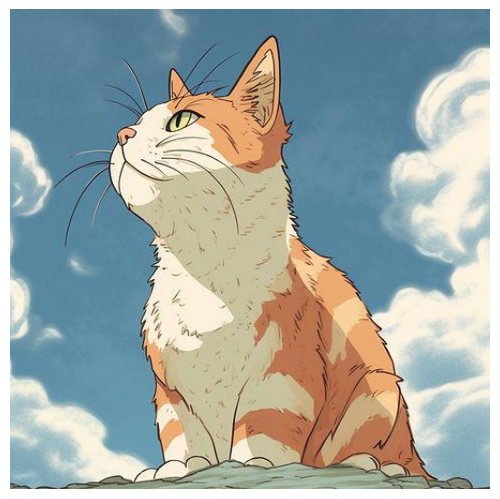

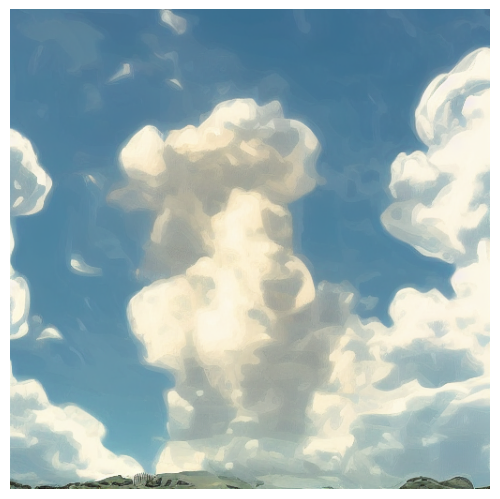

In [45]:
data = load_json("/data/Hszhu/dataset/Geo-Bench-SC/annotations.json")
# data = load_json("/data/Hszhu/dataset/PIE-Bench_v1/Subset_0/coarse_input_full_pack_0.json")
da_n = '20' #27 102
ins_id = '0'
edit_id = '5'
da = data[da_n]
instances = da['instances']
edit_meta = instances[ins_id]
coarse_input_pack = edit_meta[edit_id]

mask_pool = prepare_mask_pool(instances)
constrain_areas_strict = get_constrain_areas(mask_pool)
constrain_areas_strict  = cv2.resize(constrain_areas_strict , dsize=(512,512), interpolation=cv2.INTER_NEAREST)

# edit_prompt = coarse_input_pack['edit_prompt']
# edit_param = coarse_input_pack['edit_param']

ori_img = cv2.imread(coarse_input_pack['ori_img_path'])  # bgr
ori_img = cv2.cvtColor(ori_img, cv2.COLOR_BGR2RGB)
# ori_caption  = coarse_input_pack['tag_caption']
ori_mask = cv2.imread(coarse_input_pack['ori_mask_path'])
# obj_label = coarse_input_pack['obj_label']
target_mask = cv2.imread(coarse_input_pack['tgt_mask_path'])
# ddpm_region_mask =  cv2.imread(coarse_input_pack['ddpm_region_path'])
# coarse_input = cv2.imread(coarse_input_pack['coarse_input_path'])  # bgr
# coarse_input = cv2.cvtColor( coarse_input , cv2.COLOR_BGR2RGB)
# temp_view_img(coarse_input)
ori_mask = cv2.resize(ori_mask, dsize=target_mask.shape[:2], interpolation=cv2.INTER_NEAREST)
dilation_factor = 30
forbit_area = constrain_areas_strict-ori_mask
dil_ori_mask = dilate_mask(ori_mask, dilation_factor)
dil_ori_mask = np.where(forbit_area,0,dil_ori_mask)
Image.fromarray(dil_ori_mask).save('obj_remove_mask.png')
# #re editing 2D for vis
# new_edit_param = [0,0,0,0,0,0,0.4,0.4,1]
# coarse_input,target_mask = re_edit_2d(ori_img,ori_mask,new_edit_param,inp_back_ground)
# save_img_cr = Image.fromarray(coarse_input)
# save_img_cr.save("new_edit_cr.png")
# temp_view_img(coarse_input)
seed_r = 3787517166  # 3787517166 #4255183641 #4255183641 #2391550765
seed_r = random.randint(0, 10 ** 16)
# seed_r = 1181241943
# draw_mask =  cv2.imread("/data/Hszhu/Reggio/data_gen_utils/draw_mask_penguin.png")  # bgr
# draw_mask = cv2.imread("/data/Hszhu/Reggio/draw_mask_penguin.png")  # bgr
# temp_view(draw_mask)
# generated_results,exp_target_mask = model.generated_refine_results(ori_img,ori_mask,coarse_input,target_mask,constrain_areas_strict,obj_label,guidance_scale=7.5,eta=1.0,contrast_beta = 1.67,
#                                                    end_step = 0, num_step = 50, start_step = 25,use_mtsa = True,feature_injection=False,local_text_edit=True,local_ddpm=True,verbose=True, obj_label= obj_label)#add gen_res in input_pack
seed_r = 42
generated_results = model.Reggio_background_generation(ori_img, dil_ori_mask, "", guidance_scale=7.5,
                                                           eta=1.0, end_step=35, num_step=50,
                                                           start_step=1, share_attn=True, method_type='hcaa',
                                                           local_text_edit=True,
                                                           local_ddpm=True, verbose=True,
                                                           seed=seed_r,
                                                           return_intermediates=False,
                                                           )  # add gen_res in input_pack
temp_view_img(ori_img)
temp_view_img(generated_results)
save_img = Image.fromarray(generated_results)
save_img.save("generated_results.png")
  #TODO: BLENDING
blended = False
# output_image = cv2.resize(output_image, (512, 512), interpolation=cv2.INTER_LANCZOS4)
if blended:
    # TODO, assert ndarray

    # blur, you can adjust the parameters for better performance
    mask_blurred = cv2.GaussianBlur(ori_mask, (1, 1), 0) / 255
    mask_np = 1 - (1 - ori_mask) * (1 - mask_blurred)
    image_pasted = ori_img * (1 - mask_np) + generated_results * mask_np
    image_pasted = image_pasted.astype(generated_results.dtype)
    temp_view_img(image_pasted)